# 24784 - Trustworthy AI Autonomy (Homework 2)

## Instructions
In this homework you are going to experiment with two model-based reinforcement learning (MBRL) algorithms. You will first code the missing part in models using [PyTorch](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and [GPyTorch](https://docs.gpytorch.ai/en/stable/).
You will then implement your algorithms to control a vehicle in an parking in [highway-env](https://github.com/eleurent/highway-env). This homework is modefied based on the colab [template](https://colab.research.google.com/github/eleurent/highway-env/blob/master/scripts/parking_model_based.ipynb#scrollTo=NwCDLD1wfvi2) from Edouard Leurent.

The main experiments uses **parking-v0** environment. The goal is to park a vehicle to a given goal location with the appropriate heading by controlling the gas pedal and steering angle.


## 0. Install and import packages



In [ ]:
# Install environment
!pip install numpy==1.23.5
!pip install highway-env==1.5
!pip install pyvirtualdisplay
!apt-get update

# Install visualization and Gaussian processes dependencies
!apt-get install -y xvfb python3-opengl ffmpeg -y
!pip install gpytorch
!pip install moviepy
!pip install imageio_ffmpeg

In [16]:
# Import environment
import gymnasium as gym
import highway_env
import warnings
warnings.filterwarnings('ignore')

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
import gpytorch
from gpytorch.constraints import GreaterThan, Positive, LessThan

#suppress trivial warning from gpytorch
import warnings
warnings.filterwarnings("ignore", message="CG terminated in 1000 iterations")

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gymnasium.wrappers import RecordVideo
import base64

# IO
from pathlib import Path

Here is a simple helper function for visualization of episodes directly in this Colab notebook:



In [17]:
# Start a headless display (runs in the background, does not block)
# Start the virtual display in a way that returns immediately
if "display" not in globals():
    display = Display(visible=0, size=(1400, 900))
    display.start()
print("✅ Virtual display started")

def show_videos(path="videos"):
    """Render recorded videos inline in the notebook."""
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(f"""
            <video alt="{mp4}" autoplay loop controls style="height:400px;">
              <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
            </video>
        """)
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


✅ Virtual display started


Here we set up the parking environment

In [24]:
# Create the parking environment with proper render_mode
VIDEO_PATH = "./videos"

env = gym.make("parking-v0", render_mode="rgb_array")

# Record every episode
env = RecordVideo(env, video_folder=VIDEO_PATH, episode_trigger=lambda e: True)

# Hook highway-env's internal video recorder
# env.unwrapped.set_record_video_wrapper(env)

print("✅ Environment and video recording set up")


✅ Environment and video recording set up


To see the configuration, run the following:

In [53]:
display.stop()  # Stop the virtual display

In [ ]:
# Safe Virtual Display Starter
from pyvirtualdisplay import Display
import psutil

def start_virtual_display(width=1400, height=900):
    """Start Xvfb safely, avoiding duplicate processes."""
    global display

    # Look for any running Xvfb processes
    xvfb_procs = [p for p in psutil.process_iter(attrs=['name']) if p.info['name'] == 'Xvfb']

    if "display" in globals() and hasattr(display, "is_alive") and display.is_alive():
        print("✅ Virtual display already running")
    elif xvfb_procs:
        print(f"⚠️ An Xvfb process is already running (PID={xvfb_procs[0].pid})")
        # Attach to it instead of starting a new one
        display = Display(visible=0, size=(width, height))
        display._obj.pid = xvfb_procs[0].pid
    else:
        display = Display(visible=0, size=(width, height))
        display.start()
        print("✅ New virtual display started")

start_virtual_display()


In [ ]:
# Safe Virtual Display Stopper
def stop_virtual_display():
    global display
    if "display" in globals() and hasattr(display, "is_alive") and display.is_alive():
        display.stop()
        print("🛑 Virtual display stopped")
    else:
        print("ℹ️ No active virtual display to stop")

stop_virtual_display()

In [19]:
env.unwrapped.config

{'observation': {'type': 'KinematicsGoal',
  'features': ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
  'scales': [100, 100, 5, 5, 1, 1],
  'normalize': False},
 'action': {'type': 'ContinuousAction'},
 'simulation_frequency': 15,
 'policy_frequency': 5,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 300,
 'centering_position': [0.5, 0.5],
 'scaling': 7,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'reward_weights': [1, 0.3, 0, 0, 0.02, 0.02],
 'success_goal_reward': 0.12,
 'collision_reward': -5,
 'steering_range': np.float64(0.7853981633974483),
 'duration': 100,
 'controlled_vehicles': 1,
 'vehicles_count': 0,
 'add_walls': True}

## 1.1. Running an episode with random actions

The environment is a `GoalEnv` type, which means the agent receives a dictionary containing both the current `observation` and the `desired_goal` that conditions its policy. In this case, `observation` or `achieved_goal` is the current states and `desired_goal` are the target.

In [20]:
import random
import numpy as np
import torch

# Pick your seed (any integer)
SEED = 42

# Python's built-in RNG
random.seed(SEED)

# NumPy
np.random.seed(SEED)

# PyTorch (CPU and CUDA)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)  # for multi-GPU setups

# Ensure deterministic behavior in PyTorch (optional, can slow down training)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"✅ Random seed set to {SEED}")


✅ Random seed set to 42


In [21]:
print(f"{env.action_space}")
print(f"{env.observation_space}")

Box(-1.0, 1.0, (2,), float32)
Dict('achieved_goal': Box(-inf, inf, (6,), float64), 'desired_goal': Box(-inf, inf, (6,), float64), 'observation': Box(-inf, inf, (6,), float64))


In [30]:
#run an episode
# env.reset() #resetting the environment to start from a randomized state
'''Proper method of starting in Gymnasium documentation'''
obs, info = env.reset()
done = False

rewards = []
states = []

'Example here: https://gymnasium.farama.org/introduction/basic_usage/'
while not done:
    action = env.action_space.sample() #use random actions
    obs, reward, terminated, truncated, info = env.step(action)    # REPLACE THE THREE DOTS WITH YOUR OWN CODE

    done = terminated or truncated

    #store the state and reward in a list
    rewards.append(reward) #store the reward in a list
    # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    states.append(obs) #store the state in a list
env.close()

#Which variable does store the achieved_goal or observation (s_n) and the desired_goal (s^*)?
# REPLACE THE THREE DOTS WITH YOUR OWN CODE
print(f"Achieved goal / observation (s_n): {states[-1]["achieved_goal"]}")
print(f"Desired goal (s^*): {states[-1]["desired_goal"]}")


print(f"Also prints 'Achieved Goal is env.unwrapped.vehicle.destination: {env.unwrapped.vehicle.destination}")


Achieved goal / observation (s_n): [-0.31846381 -0.01839052 -1.53935526 -0.94555326 -0.8520885  -0.52339774]
Desired goal (s^*): [2.200000e-01 1.400000e-01 0.000000e+00 0.000000e+00 6.123234e-17
 1.000000e+00]
Also prints 'Achieved Goal is env.unwrapped.vehicle.destination: [-31.84638102  -1.8390521 ]


Target state (s*): [2.200000e-01 1.400000e-01 0.000000e+00 0.000000e+00 6.123234e-17
 1.000000e+00]
Final state at t=100 (s_n): [ 0.16523189 -0.08377194 -0.64545489  0.23566416 -0.93934705  0.34296809]


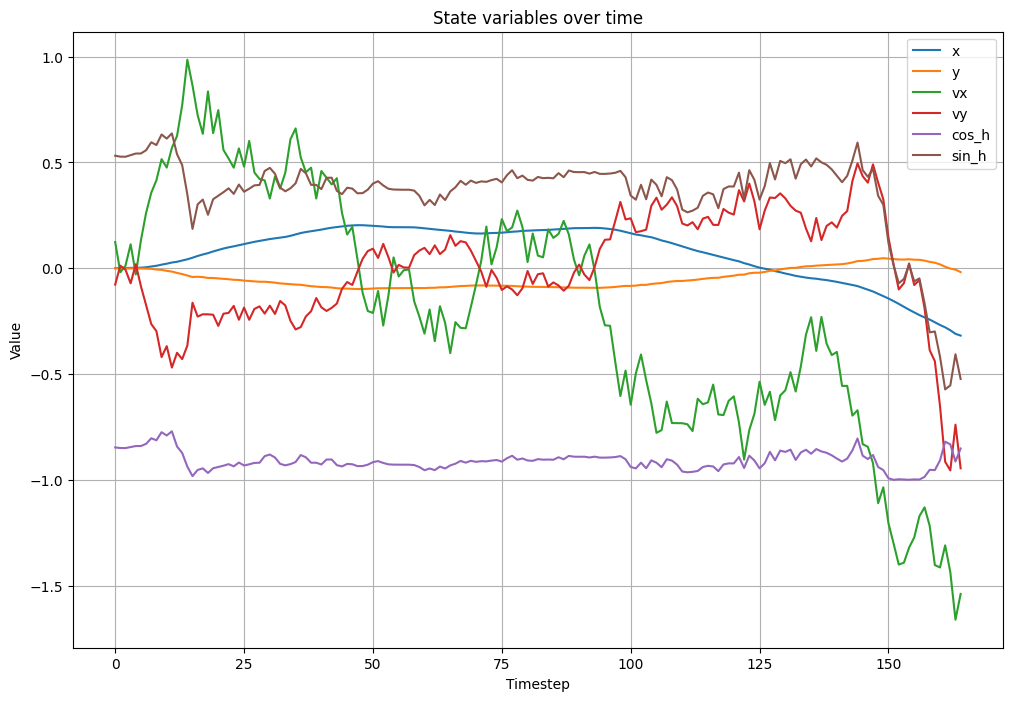

In [52]:
'''
Observation dictionary looks like this:
OrderedDict({
    "observation": array([...]),   # ego kinematics
    "achieved_goal": array([...]), # same as observation, but in goal-space
    "desired_goal": array([...])   # fixed target state
})
'''
observations  = np.stack([s["observation"]   for s in states])      
achieved_goals = np.stack([s["achieved_goal"] for s in states])  # shape: (165, 6)
desired_goals  = np.stack([s["desired_goal"]  for s in states])  #

s_star = desired_goals[0]   # desired goal is constant for the whole episode
s_n    = achieved_goals[100]  # final state at timestep 100

print("Target state (s*):", s_star)
print("Final state at t=100 (s_n):", s_n)

import matplotlib.pyplot as plt

features = ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h']

plt.figure(figsize=(12,8))
for i, feat in enumerate(features):
    plt.plot(observations[:, i], label=feat)

plt.title("State variables over time")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## 1.2. Reward definition

The reward (or more specifically penalty, as it uses negative sign) here is the difference between the current state to the targe (parking space).

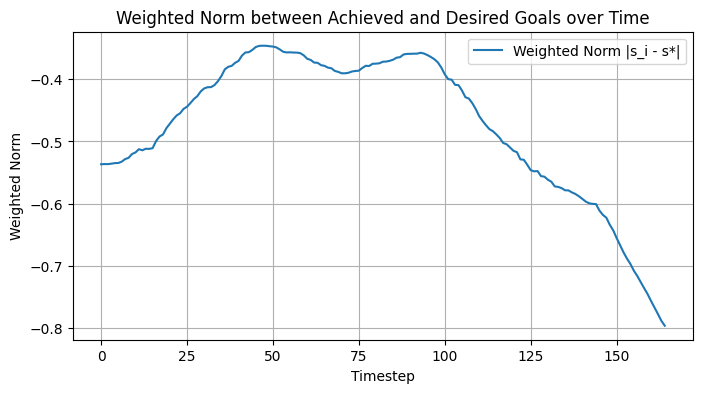

In [51]:
#Negative reward
states_labels = env.unwrapped.config['observation']['features'] #the labels for the states
states_scales = env.unwrapped.config['observation']['scales'] #the scales for the states (if needed for plotting)

weights = np.array([1, 0.3, 0, 0, 0.02, 0.02]) #weights
# print(states)

'''Need to pull out achieved and desired goals for weighted norm calculation
from states list of dicts to array of arrays'''
achieved = np.stack([s["achieved_goal"] for s in states])  # shape: (165, 6)
desired  = np.stack([s["desired_goal"]  for s in states])  # shape: (165, 6)

# weighted norm per timestep
weighted_norm = -np.sqrt((weights * np.abs(achieved - desired)).sum(axis=1))   # (165,)

#plot the weighted norm over time
# REPLACE THE THREE DOTS WITH YOUR OWN CODE
plt.figure(figsize=(8, 4))
plt.plot(weighted_norm, label="Weighted Norm |s_i - s*|")
plt.xlabel("Timestep")
plt.ylabel("Weighted Norm")
plt.title("Weighted Norm between Achieved and Desired Goals over Time")
plt.legend()
plt.grid(True)
plt.show()


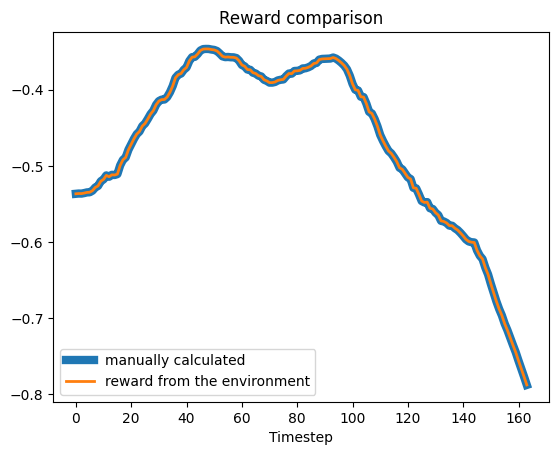

In [43]:
#not needed, but as hinted:
#might be useful to compare the calculated weighted norm with the actual reward
#they should be the same if your calculation is correct

#Reward comparison
plt.plot(weighted_norm[:-1], lw=6, label="manually calculated")
plt.plot(rewards[:-1], lw=2, label="reward from the environment")
plt.title('Reward comparison')
plt.xlabel('Timestep')
plt.legend()
plt.show()

##1.3 Final reward and vehicle trajectory



Reward at final timestep: -5.795921284536214


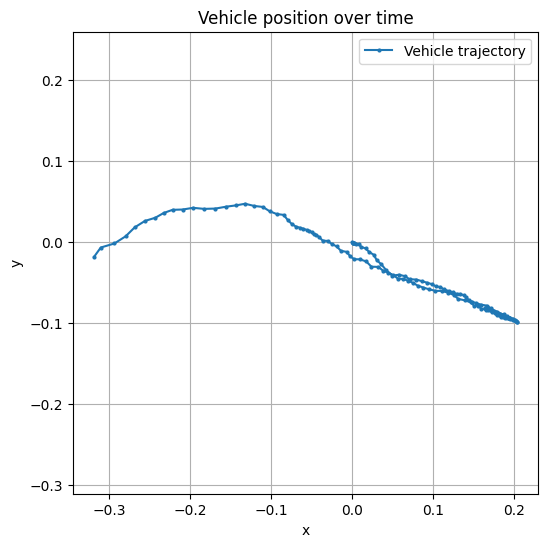

In [44]:
# final reward
final_reward = rewards[-1]
print("Reward at final timestep:", final_reward)

# Plot the trajectory of the vehicle (x and y position over timestep)
# Pull out x and y coordinates
positions = achieved[:, :2]   # shape (T,2)
x, y = positions[:,0], positions[:,1]

plt.figure(figsize=(6,6))
plt.plot(x, y, marker="o", markersize=2, label="Vehicle trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Vehicle position over time")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

In [48]:
#load the video of the episode
show_videos('./videos')

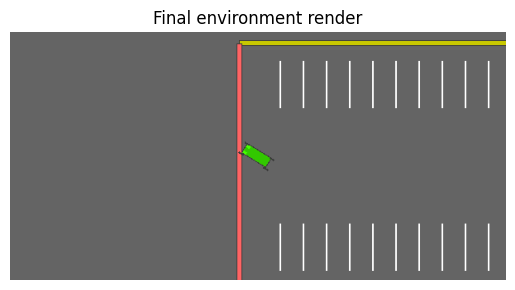

In [49]:
# Render final state (only works if env is still active)
img = env.render()  # will return an RGB array if render_mode="rgb_array"

plt.imshow(img)
plt.axis("off")
plt.title("Final environment render")
plt.show()

### 2.1 Build a dynamics model with NN


In [55]:
# reinitialize the env without recordvideo
env = gym.make("parking-v0")
obs, info = env.reset()

In [56]:
#NN structure
class NN_DynamicsModel(nn.Module):
    name = 'NN'
    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        self.layer1 = nn.Linear(state_size + action_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, state_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        :return x_{t+1}
        """
        xu = torch.cat((x, u), -1)
        xu = F.relu(self.layer1(xu))
        dx = self.layer2(xu).squeeze()

        # note that our prediction is delta x: dx = x_{t+1} - x_{t},
        # so how to obtain x_{t+1}?

        x_next = x + dx # REPLACE THE THREE DOTS WITH YOUR OWN CODE
        return x_next

Build NN dynamics model:

In [57]:
#parameters to instantiate the NN model
state_size = env.observation_space.spaces["observation"].shape[0] #observation dimension
action_size = env.action_space.shape[0] #action dimension
hidden_size = 128 #width of the hidden layer
timestep_duration = 1/env.unwrapped.config["policy_frequency"] #timestep duration of the environment

#instatiate the NN model
dynamics_nn = NN_DynamicsModel(state_size, action_size, hidden_size, timestep_duration)  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

In [61]:
#run a full episode with random actions and store the untrained nn predictions
state_data = []
pred_data = []
reward_data = []

#initialize the environment
obs, info = env.reset()
done = False

while not done:
    action = env.action_space.sample() #use random actions
    obs, reward, terminated, truncated, info = env.step(action)    # REPLACE THE THREE DOTS WITH YOUR OWN CODE

    done = terminated or truncated

    #store the state and reward in a list
    reward_data.append(reward) #store the reward in a list
    # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    state_data.append(obs["observation"]) #store the state in a list

    # convert to tensors for NN
    state_tensor  = torch.tensor(obs["observation"], dtype=torch.float32).unsqueeze(0)
    action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

    # predict next state
    pred = dynamics_nn(state_tensor, action_tensor).detach().numpy().squeeze()  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

    #store the data
    pred_data.append(pred)  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

env.close()

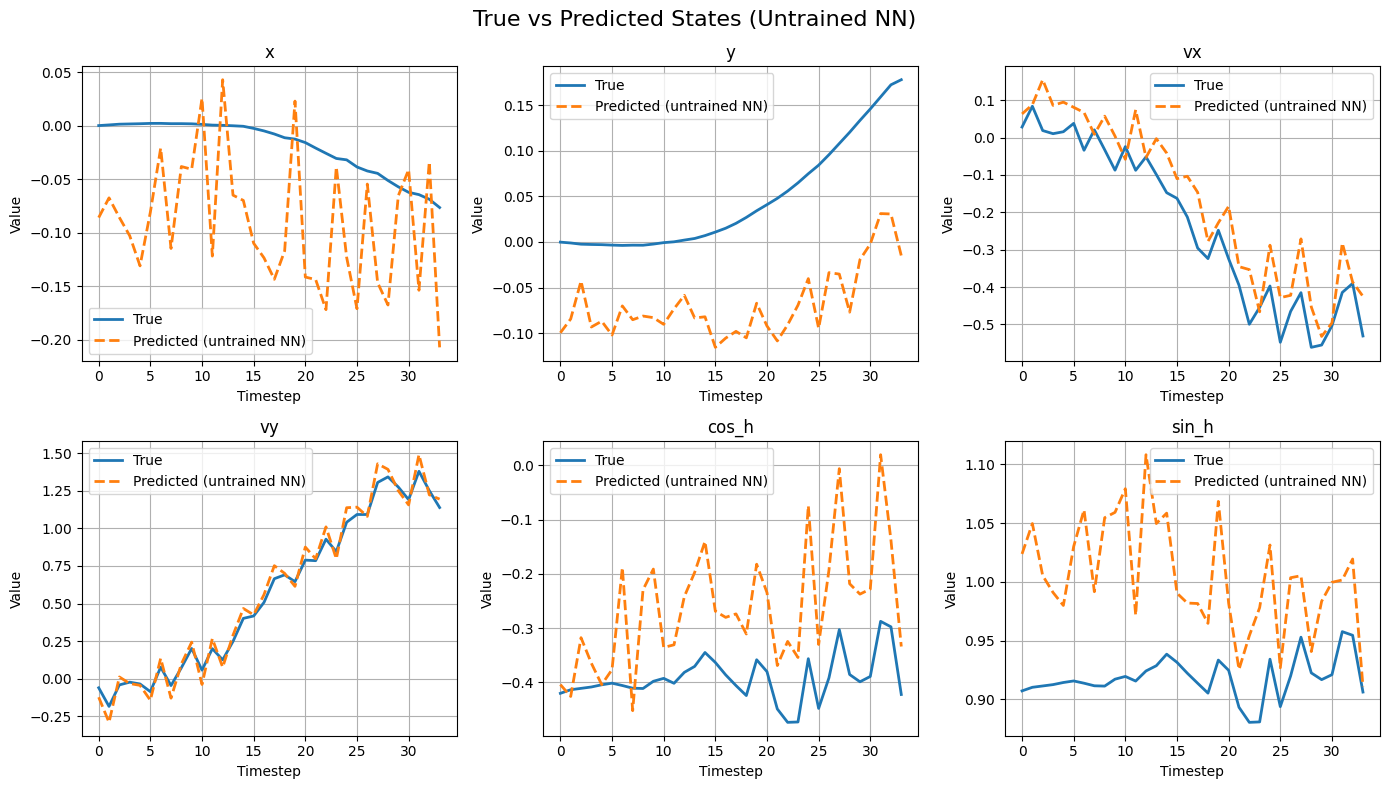

In [62]:
# Plot the true and predicted states
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

import matplotlib.pyplot as plt
import numpy as np

# Convert lists into arrays
true_states = np.array(state_data)   # shape (T, state_size)
pred_states = np.array(pred_data)    # shape (T, state_size)

features = ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h']

plt.figure(figsize=(14, 8))

for i, feat in enumerate(features):
    plt.subplot(2, 3, i+1)
    plt.plot(true_states[:, i], label="True", linewidth=2)
    plt.plot(pred_states[:, i], "--", label="Predicted (untrained NN)", linewidth=2)
    plt.title(feat)
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

plt.suptitle("True vs Predicted States (Untrained NN)", fontsize=16)
plt.tight_layout()
plt.show()


## 2.2 Model training

First, we randomly interact with the environment to produce a batch of experiences.
$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [65]:
#functions to create experiences dataset D

Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=2000, action_repeat=1):
    data, done = [], True
    obs, info = env.reset()
    for _ in trange(size):
        action = env.action_space.sample() #random sample actions
        for _ in range(action_repeat):
            if done:
                obs, info = env.reset()

            previous_obs = obs  # store before stepping
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
    return data

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

In [66]:
size = 2000  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

data = collect_interaction_data(env, size=size)

print("Sample transition:", data[0])
print("Buffer size:", len(data))

  0%|          | 0/2000 [00:00<?, ?it/s]

Sample transition: Transition(state=tensor([ 0.0000,  0.0000,  0.0000, -0.0000,  0.9081, -0.4188]), action=tensor([ 0.8594, -0.4520]), next_state=tensor([ 4.6751e-04, -3.3115e-04,  1.5578e-01, -7.2625e-02,  9.0634e-01,
        -4.2255e-01]))
Buffer size: 2000


In [67]:
# Split dataset into training and validation

train_ratio = 0.7 # REPLACE THE THREE DOTS WITH YOUR OWN CODE

train_data, validation_data = data[:int(train_ratio * len(data))], \
                              data[int(train_ratio * len(data)):]

In [68]:
# functions to train the model

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def train(model, train_data, validation_data, epochs=1500, learning_rate = 0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)

    for epoch in trange(epochs):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["training", "validation"])
    plt.show()

Training the model

  0%|          | 0/1000 [00:00<?, ?it/s]

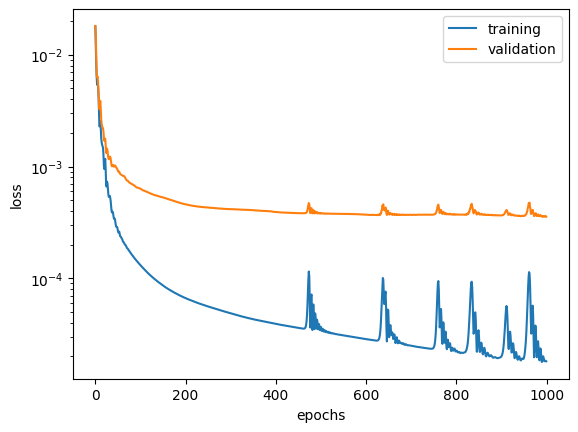

In [69]:
num_epochs = 1000 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
learning_rate = .01 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
train(dynamics_nn, train_data, validation_data, epochs=num_epochs, learning_rate = learning_rate)

## 2.3 Predictions of the trained NN

In [71]:
dynamics_nn.eval() #set the trained model for use

#run a full episode with random actions and store the trained nn predictions
state_data = []
pred_data = []
reward_data = []

#initialize the environment
obs, info = env.reset()
done = False

while not done:
    action = env.action_space.sample() #use random actions
    'Model was trained using previous obs, so store that'
    prev_obs = obs["observation"]

    # take a step in the env
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # true next state
    state_data.append(obs["observation"])
    reward_data.append(reward)

    # convert prev_obs and action into tensors for NN
    state_tensor  = torch.tensor(prev_obs, dtype=torch.float32).unsqueeze(0)
    action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

    # NN prediction of next state
    pred = dynamics_nn(state_tensor, action_tensor).detach().numpy().squeeze()
    pred_data.append(pred)
    
env.close()


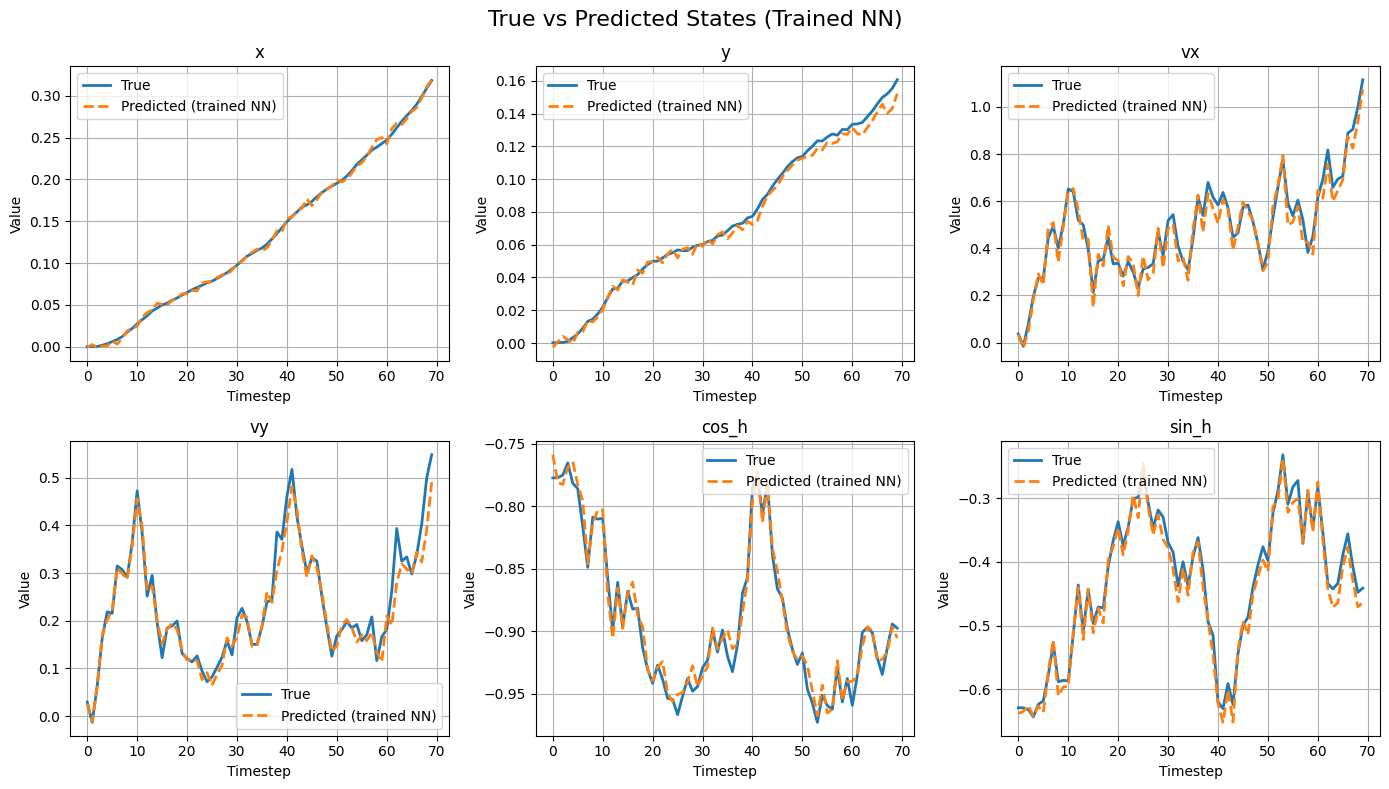

In [72]:
# Plot the true and predicted states
states = np.array(state_data)
preds = np.array(pred_data)

# REPLACE THE THREE DOTS WITH YOUR OWN CODE
# Plot true vs predicted states
features = ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h']
plt.figure(figsize=(14, 8))

for i, feat in enumerate(features):
    plt.subplot(2, 3, i+1)
    plt.plot(states[:, i], label="True", linewidth=2)
    plt.plot(preds[:, i], "--", label="Predicted (trained NN)", linewidth=2)
    plt.title(feat)
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

plt.suptitle("True vs Predicted States (Trained NN)", fontsize=16)
plt.tight_layout()
plt.show()

nn_error = ((states-preds)**2).mean()

## CEM planner


In [73]:
#functions to help build the  CEM method
def predict_trajectory_actionlist(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            if model.name == 'GP':
                state = model(torch.cat((state, action), -1)).mean
            else:
                state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards

We now use the learnt dynamics model $f_\theta$ for planning.
In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the **Cross-Entropy Method** (`CEM`). It is an optimization algorithm applicable to problems that are both **combinatorial** and **continuous**, which is our case: find the best performing sequence of actions.

In [74]:
def cem_planner(state, goal, action_size, model, horizon=5, population=10, selection=5, iterations=5):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)

    for _ in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        actions = action_mean + action_std * torch.randn(horizon, population, action_size)
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        # 2. Predict state trajectories with the dynamics model
        states = predict_trajectory_actionlist(state, actions, model, action_repeat=horizon)

        # 3. Fit the distribution to the top-k performing sequences
        returns = reward_model(states, goal).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]

        # Update the action distribution
        action_std = best_actions.std(dim=1, unbiased=False, keepdim=True)
        action_mean = best_actions.mean(dim=1, keepdim=True) # REPLACE THE THREE DOTS WITH YOUR OWN CODE

    return action_mean[0].squeeze(dim=0)


Example of using the CEM to select actions:

In [75]:
# Run the planner on a sample transition

obs,info = env.reset() #reset the environment to start

#run CEM to get actions using NN dynamics model
H = 3 #planning horizon
K = 10 #population size

action_nn = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0], dynamics_nn,
                     horizon=H, population=K)

print("Planned action:", action_nn)

Planned action: tensor([-0.5689,  0.2210])


## 2.4. CEM with NN model

In [77]:
#run an episode for nn

#run an episode with random actions for at most n time steps
n = 20 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
H = 5 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
K = 10 # REPLACE THE THREE DOTS WITH YOUR OWN CODE

import time

nn_time = []
state_data_nn = []
reward_data_nn = []

obs, info = env.reset()
done = False
i=0 #iterates

while (not done and i < n) :

    #use CEM with NN model to select actions
    start = time.time()
    state = torch.tensor(obs["observation"], dtype=torch.float32).unsqueeze(0)
    target = torch.tensor(obs["desired_goal"], dtype=torch.float32)

    action = cem_planner(state, target, env.action_space.shape[0],
                         dynamics_nn, horizon=H, population=K,
                         selection=K//2, iterations=5).detach().numpy()

    # step in environment (Gymnasium API)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    end = time.time()
    # store the data
    state_data_nn.append(obs["observation"])
    reward_data_nn.append(reward)
    nn_time.append(end - start)

    i += 1
    print(f"Step {i} complete")

env.close()
nn_reward = reward_data_nn

Step 1 complete
Step 2 complete
Step 3 complete
Step 4 complete
Step 5 complete
Step 6 complete
Step 7 complete
Step 8 complete
Step 9 complete
Step 10 complete
Step 11 complete
Step 12 complete
Step 13 complete
Step 14 complete
Step 15 complete
Step 16 complete
Step 17 complete
Step 18 complete
Step 19 complete
Step 20 complete


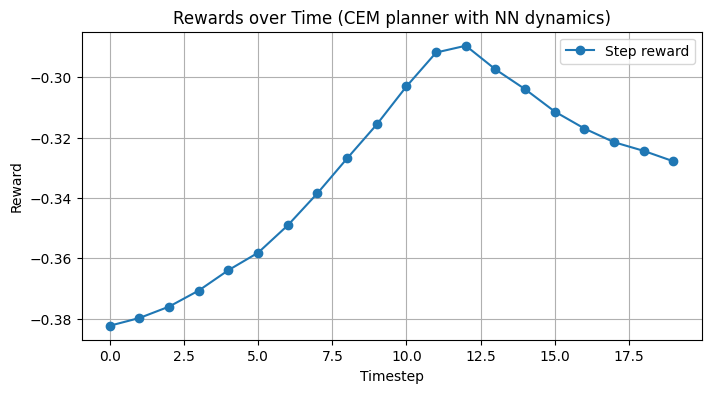

In [78]:
# Plot the rewards over time step

import matplotlib.pyplot as plt
import numpy as np

rewards_arr = np.array(nn_reward)

plt.figure(figsize=(8,4))
plt.plot(rewards_arr, marker="o", label="Step reward")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.title("Rewards over Time (CEM planner with NN dynamics)")
plt.grid(True)
plt.legend()
plt.show()


### 3.1 Build a dynamics model with a Gaussian process

In [79]:
#GP model structure
#More details are available in gpytorch documentation: https://docs.gpytorch.ai/en/stable/

import gpytorch
from torch.utils.data import DataLoader

class MultitaskGPModel(gpytorch.models.ExactGP):
    name = 'GP'
    def __init__(self, train_x, train_y, likelihood, num_tasks=6): # number tasks is equivalent to the output dim
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.num_tasks = num_tasks
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        dists = gpytorch.distributions.MultitaskMultivariateNormal(mean_x + x[:,:self.num_tasks], covar_x)
        return dists

Build data pre-processing and prediction functions

In [80]:
#functions to prepare the data for GP training

def GP_dataloader_process(data, train_ratio = 0.3):
    # Split dataset into training and validation
    data_n = transpose_batch(data)
    inputs = torch.cat((data_n[0], data_n[1]), dim=1)
    targets = data_n[2]
    data_for_loader = []

    for i in range(inputs.shape[0]):
      data_for_loader.append([inputs[i], targets[i]])

    # prepare data for loader
    train_data_for_loader, validation_data_for_loader = data_for_loader[:int(train_ratio * len(data))], data_for_loader[int(train_ratio * len(data)):]

    # prepare data for GP
    return train_data_for_loader, validation_data_for_loader

def GP_data_prepare(data, train_ratio = 0.3):
    # Split dataset into training and validation
    train_data, validation_data = data[:int(train_ratio * len(data))], \
                                  data[int(train_ratio * len(data)):]
    train_data_t = transpose_batch(train_data)
    states, actions, next_states = train_data_t
    train_x = torch.cat((states, actions), -1)
    train_y = next_states

    validation_data_t = transpose_batch(validation_data)
    val_states, val_actions, val_next_states = validation_data_t
    val_x = torch.cat((val_states, val_actions), -1)
    val_y = val_next_states
    return [train_x, train_y], [val_x, val_y]

def predict_trajectory(state, action, model, action_repeat=1):
    states = []
    for _ in range(action_repeat):
        if model.name == 'GP':
            state = model(torch.cat((state, action), -1)).mean
        else:
            state = model(state, action)
        states.append(state)
    return torch.stack(states, dim=0)

Training the GP model

In [81]:
train_ratio = 0.2

#prepare and split the dataset
train_data, validation_data = GP_data_prepare(data, train_ratio=train_ratio)
train_x, train_y = train_data
val_x, val_y = validation_data

# construct dynamics model
output_dim = 6 #the dimension of the state variables
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim, noise_constraint=GreaterThan(0.000001))

#instantiate the model
dynamics_gp = MultitaskGPModel(train_x, train_y, likelihood, num_tasks=output_dim)

In [82]:
learning_rate = 0.2 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
epochs = 15 # REPLACE THE THREE DOTS WITH YOUR OWN CODE

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, dynamics_gp) #loss function
optimizer = torch.optim.Adam([{'params': dynamics_gp.parameters()},], lr=learning_rate) #adam optimizer

losses = np.full((epochs, 2), np.nan) #instantiate variables to store loss values

In [83]:

#iterate the training
for i in trange(epochs):
    dynamics_gp.train()
    likelihood.train()
    optimizer.zero_grad()

    output = dynamics_gp(train_x)
    loss = -mll(output, train_y) #compute the loss
    loss.backward() #backprop the error
    optimizer.step() #update the nn params

    dynamics_gp.eval()
    likelihood.eval()
    val_out = dynamics_gp(val_x)
    validation_loss = -mll(val_out, val_y) #compute the validation loss

    losses[i] = [loss.detach().numpy(), validation_loss.detach().numpy()] #store the computed loss

    print('Iter %d/%d - Loss: %.3f - Val Los: %.3f' % (i + 1, epochs, loss.item(), validation_loss.item()))

  0%|          | 0/15 [00:00<?, ?it/s]

Iter 1/15 - Loss: 1.235 - Val Los: 1.073
Iter 2/15 - Loss: 1.138 - Val Los: 0.982
Iter 3/15 - Loss: 1.040 - Val Los: 0.893
Iter 4/15 - Loss: 0.944 - Val Los: 0.803
Iter 5/15 - Loss: 0.849 - Val Los: 0.711
Iter 6/15 - Loss: 0.753 - Val Los: 0.621
Iter 7/15 - Loss: 0.657 - Val Los: 0.526
Iter 8/15 - Loss: 0.561 - Val Los: 0.431
Iter 9/15 - Loss: 0.463 - Val Los: 0.335
Iter 10/15 - Loss: 0.365 - Val Los: 0.238
Iter 11/15 - Loss: 0.267 - Val Los: 0.140
Iter 12/15 - Loss: 0.168 - Val Los: 0.041
Iter 13/15 - Loss: 0.070 - Val Los: -0.059
Iter 14/15 - Loss: -0.029 - Val Los: -0.159
Iter 15/15 - Loss: -0.128 - Val Los: -0.260


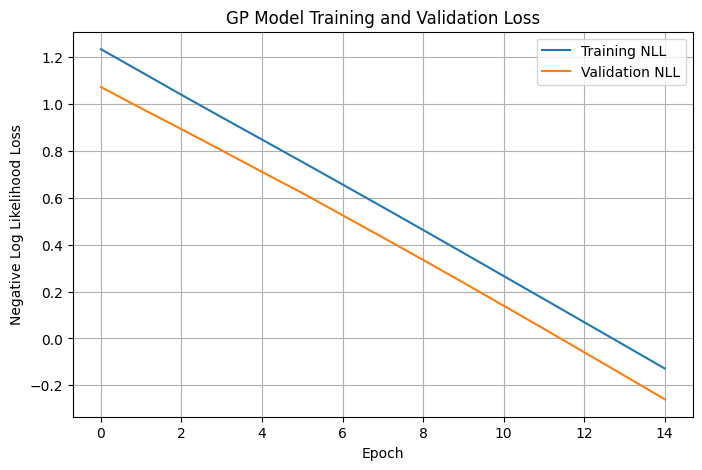

In [84]:
# Plot the training and validation losses

plt.figure(figsize=(8,5))
plt.plot(losses[:,0], label="Training NLL")
plt.plot(losses[:,1], label="Validation NLL")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood Loss")
plt.title("GP Model Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

##3.2 Using the trained model for prediction

In [86]:
#run an episode with random actions for at most n time steps
n = 20

state_data_gp = []
pred_data_gp = []
reward_data_gp = []

obs, info = env.reset()
done = False
i=0 #iterates

while (not done and i < n):

    # random action
    action = env.action_space.sample()

    # take a step in the environment (Gymnasium API)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # convert to tensors for GP prediction
    state_tensor  = torch.tensor(obs['observation'], dtype=torch.float32).unsqueeze(0)
    action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

    # GP prediction of next state
    pred = predict_trajectory(state_tensor, action_tensor, dynamics_gp, action_repeat=1)
    pred = pred.detach().numpy().squeeze()  # GP outputs a distribution

    # store data
    state_data_gp.append(obs['observation'])
    pred_data_gp.append(pred)
    reward_data_gp.append(reward)

    i += 1
    print(f"Step {i}")

env.close()

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20


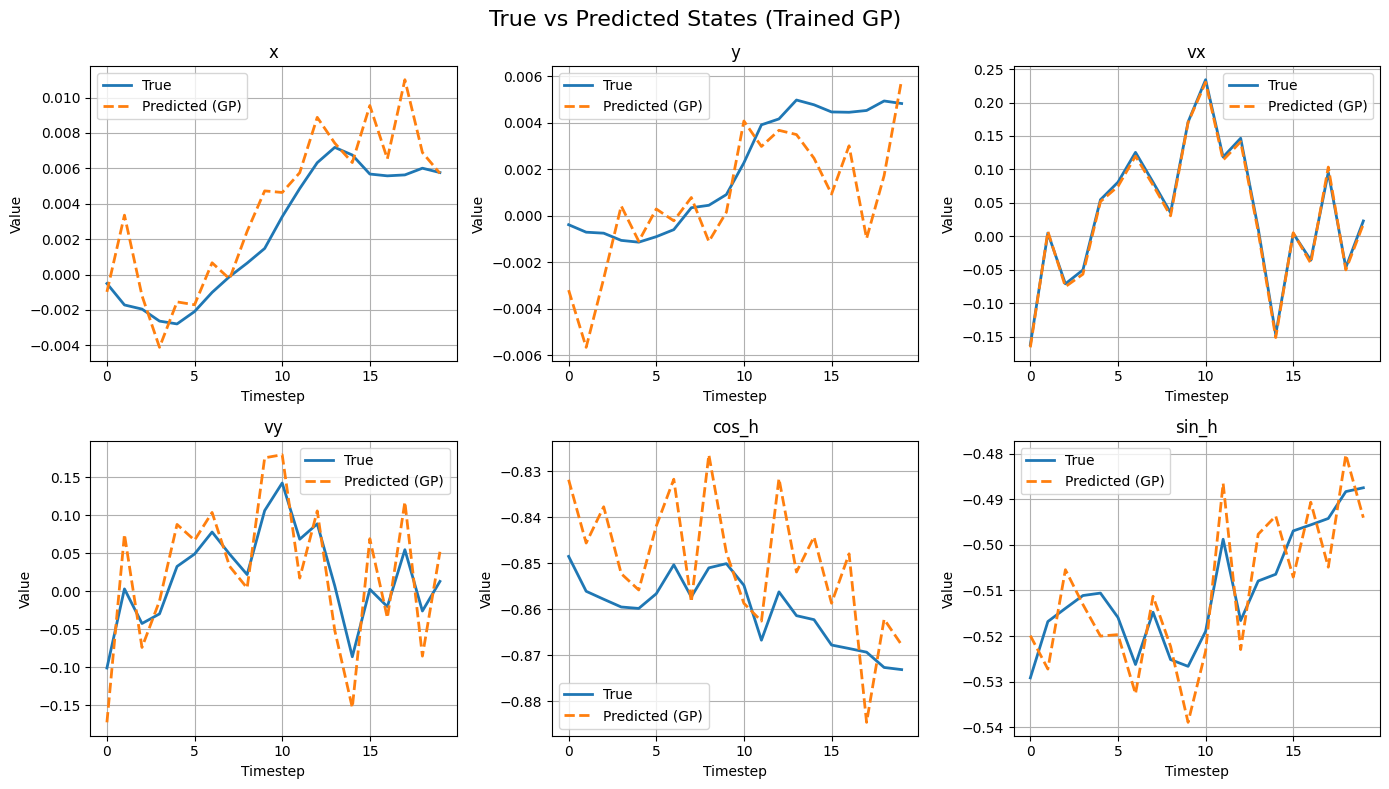

In [87]:
# Plot the true and predicted states

# convert to arrays
states_gp = np.array(state_data_gp)
preds_gp  = np.array(pred_data_gp)

# plot true vs predicted states
features = ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h']
plt.figure(figsize=(14,8))

for j, feat in enumerate(features):
    plt.subplot(2, 3, j+1)
    plt.plot(states_gp[:, j], label="True", linewidth=2)
    plt.plot(preds_gp[:, j], "--", label="Predicted (GP)", linewidth=2)
    plt.title(feat)
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

plt.suptitle("True vs Predicted States (Trained GP)", fontsize=16)
plt.tight_layout()
plt.show()

## 3.3. CEM with GP model

In [88]:
#run an episode for GP

#run an episode with random actions for at most n time steps
n = 20 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
H = 5 
K = 10 

state_data = []
reward_data = []
gp_time = []

obs, info  = env.reset()
done = False
i=0 #iterates
state = torch.Tensor(obs['observation']).unsqueeze(0)
target = torch.Tensor(obs['desired_goal']).unsqueeze(0)

while (not done and i < n) :

    start = time.time()
    # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    action = cem_planner(
        state, target, env.action_space.shape[0],
        dynamics_gp, horizon=H, population=K,
        selection=K//2, iterations=5
        ).detach().numpy() #use CEM with GP model to select actions
    
    # step in the environment (Gymnasium API)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # update tensors for next iteration
    state = torch.tensor(obs['observation'], dtype=torch.float32).unsqueeze(0)
    target = torch.tensor(obs['desired_goal'], dtype=torch.float32).unsqueeze(0)

    # predict next state with GP (optional, just for logging/debug)
    pred = predict_trajectory(state, torch.tensor(action, dtype=torch.float32).unsqueeze(0),
                              dynamics_gp, action_repeat=1).detach().numpy()
    end = time.time()

    # store the data
    state_data.append(obs['observation'])
    reward_data.append(reward)
    gp_time.append(end - start)

    i += 1
    print(f"Step {i}")

env.close()
gp_reward = reward_data

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20


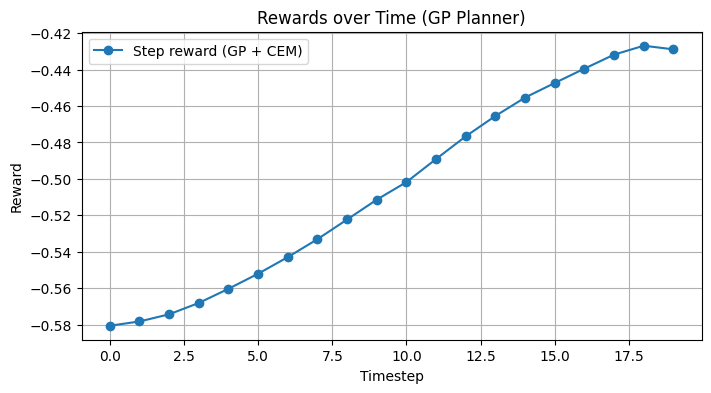

In [89]:
# Plot the rewards over time step

rewards_arr = np.array(gp_reward)

plt.figure(figsize=(8,4))
plt.plot(rewards_arr, marker="o", label="Step reward (GP + CEM)")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.title("Rewards over Time (GP Planner)")
plt.grid(True)
plt.legend()
plt.show()

In [90]:
# Get the final reward (when using NN and GP with CEM)

final_reward_nn = nn_reward[-1]
final_reward_gp = gp_reward[-1]

print(f"Final reward (NN + CEM): {final_reward_nn:.4f}")
print(f"Final reward (GP + CEM): {final_reward_gp:.4f}")

Final reward (NN + CEM): -0.3279
Final reward (GP + CEM): -0.4289


Computing the prediction error, and computation time between NN and GP

In [92]:
# Compute the prediction error of NN and GP models during the planning horizon

min_len_nn = min(len(state_data_nn), len(pred_data))
min_len_gp = min(len(state_data_gp), len(pred_data_gp))

# Compute errors
nn_error = ((np.array(state_data_nn[:min_len_nn]) - np.array(pred_data[:min_len_nn]))**2).mean()
gp_error = ((np.array(state_data_gp[:min_len_gp]) - np.array(pred_data_gp[:min_len_gp]))**2).mean()

print(f"Prediction error (NN): {nn_error:.6f}")
print(f"Prediction error (GP): {gp_error:.6f}")

# Get the computation time of running CEM with NN (from 2.4)and GP (from 3.3)
nn_time_avg = np.mean(nn_time)
gp_time_avg = np.mean(gp_time)

print(f"Average CEM runtime per step (NN): {nn_time_avg:.6f} sec")
print(f"Average CEM runtime per step (GP): {gp_time_avg:.6f} sec")

Prediction error (NN): 0.163447
Prediction error (GP): 0.000440
Average CEM runtime per step (NN): 0.013354 sec
Average CEM runtime per step (GP): 2.261211 sec


##Visualize a few episodes [Optional]

Here is a code to visualize a few episodes with CEM action planner.  This is optional, but might be helpful to gain insights.

En voiture, Simone!

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()
env = gym.make("parking-v0") #instantiate the parking environment
VIDEO_PATH = './video-final' #designate the video path
env = RecordVideo(env, video_folder=VIDEO_PATH, episode_trigger=lambda e: True, new_step_api=True)
env.unwrapped.set_record_video_wrapper(env) #set up virtual monitor to store the video files at VIDEO_PATH dir
num_episodes = 5
H = 6
K = 25
iterations = 15

#select the dynamic model
selected_dynamic_model = dynamics_nn #we will use NN model for its fast computation

for episode in trange(num_episodes):
    obs = env.reset()
    done=False
    while (not done):
        action = cem_planner(torch.Tensor(obs["observation"]),
                             torch.Tensor(obs["desired_goal"]),
                             env.action_space.shape[0], selected_dynamic_model,
                             horizon=H, population=K, iterations=iterations)
        obs, reward, done, _, info = env.step(action.numpy())
env.close()

In [ ]:
show_videos(VIDEO_PATH)